## Chapter 4 [Spectroscopy](Ch4-Spectroscopy.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Analyze Spectrum

part of 

## [Analysis of Scanning Electron Microscope Data](_Analysis_of_Scanning_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with scanning electron microscopes


## First we import the essential libraries
All we need here should come with the annaconda or any other package

The xml library will enable us to read the Bruker file.

In [87]:
%pylab --no-import-all notebook
import xml.etree.ElementTree as ET
%gui qt5

Populating the interactive namespace from numpy and matplotlib


## Select File

Please note that the above code cell has to be finished before you can open the * open file* dialog.

Test data are in the **SEM_example_data** folder, plese select EDS.rto file.

In [88]:
from PyQt5 import QtGui, QtWidgets

path = '' 
fname, file_filter = QtWidgets.QFileDialog.getOpenFileName(None, "Select a file...", path)


### Function to read Bruker files
The data and metadata will be in a python dictionary called tags.

In [89]:
import codecs

def open_Bruker(fname):
    tree = ET.parse(fname)
    root = tree.getroot()
    spectrum_number = 0
    i=0
    image_count = 0
    o_count = 0
    tags = {}
    for neighbor in root.iter():
        #print(neighbor.attrib.keys())
        if 'Type' in neighbor.attrib:
            if 'verlay3' in neighbor.attrib['Type'] :
                semImage = neighbor
                #print(neighbor.attrib['Type'])
                if 'Name' in neighbor.attrib:
                    print('\t',neighbor)
                    print('\t',neighbor.attrib['Type'])
                    print('\t',neighbor.attrib['Name'])
                    print('\t',neighbor.find("./ClassInstance[@Type='TRTSpectrumList']"))
            #if 'TRTImageOverlay' in neighbor.attrib['Type'] : 
            if 'TRTCrossOverlayElement'in neighbor.attrib['Type'] :
                if 'Spectrum' in neighbor.attrib['Name']:
                    #print(o_count)
                    o_count+=1
                    if 'overlay' not in tags:
                        tags['overlay']= {}
                    if 'image'+str(image_count) not in tags['overlay']:
                        tags['overlay']['image'+str(image_count)] ={}
                    tags['overlay']['image'+str(image_count)][neighbor.attrib['Name']] ={}

                    over = tags['overlay']['image'+str(image_count)][neighbor.attrib['Name']]


                    for child in neighbor.iter():
                        if 'verlay' in child.tag:
                            #print(child.tag)
                            pos = child.find('./Pos')
                            if pos != None:
                                over['posX'] = int(pos.find('./PosX').text) 
                                over['posY'] = int(pos.find('./PosY').text) 
                #dd = neighbor.find('Top')
                #print('dd',dd)                       
                #print(neighbor.attrib)
            if 'TRTImageData' in neighbor.attrib['Type'] :
                #print('found image ', image_count)
                dd = neighbor.find("./ClassInstance[@Type='TRTCrossOverlayElement']")
                if dd != None:
                    print('found in image')
                image = neighbor
                if 'image' not in tags:
                    tags['image']={}
                tags['image'][str(image_count)]={}
                im = tags['image'][str(image_count)]
                im['width'] = int(image.find('./Width').text)  # in pixels
                im['height'] = int(image.find('./Height').text)  # in pixels
                im['dtype'] = 'u' + image.find('./ItemSize').text  # in bytes ('u1','u2','u4') 
                im['plane_count'] = int(image.find('./PlaneCount').text)
                im['data'] = {}
                for j in range( im['plane_count']):
                    #print(i)

                    img = image.find("./Plane" + str(i))
                    raw = codecs.decode((img.find('./Data').text).encode('ascii'),'base64')
                    array1 = np.frombuffer(raw, dtype= im['dtype'])
                    #print(array1.shape)
                    im['data'][str(j)]= np.reshape(array1,(im['height'], im['width']))
                image_count +=1     
            if 'TRTDetectorHeader' == neighbor.attrib['Type'] :
                detector = neighbor
                tags['detector'] ={}
                for child in detector:
                    if child.tag == "WindowLayers":
                        tags['detector']['window']={}
                        for child2 in child:
                            tags['detector']['window'][child2.tag]={}
                            tags['detector']['window'][child2.tag]['Z'] = child2.attrib["Atom"]
                            tags['detector']['window'][child2.tag]['thickness'] = float(child2.attrib["Thickness"])*1e-5  # stupid units
                            if 'RelativeArea' in child2.attrib:
                                tags['detector']['window'][child2.tag]['relative_area'] = float(child2.attrib["RelativeArea"])
                            print(child2.tag,child2.attrib)
                            
                    else:
                        #print(child.tag , child.text)
                        if child.tag != 'ResponseFunction':
                            if child.text !=None:
                                tags['detector'][child.tag]=child.text
                                
                                if child.tag == 'SiDeadLayerThickness':
                                    tags['detector'][child.tag]=float(child.text)*1e-6
                                    print(child.tag)
                                if child.tag == 'DetectorThickness':
                                    tags['detector'][child.tag]=float(child.text)*1e-1
            # ESMA could stand for Electron Scanning Microscope Analysis
            if 'TRTESMAHeader' == neighbor.attrib['Type'] :
                esma = neighbor
                tags['esma'] ={}
                for child in esma:
                    if child.tag in ['PrimaryEnergy', 'ElevationAngle',  'AzimutAngle', 'Magnification',   'WorkingDistance' ]:
                        tags['esma'][child.tag]=float(child.text)

            if 'TRTSpectrum' == neighbor.attrib['Type'] :
                if 'Name' in neighbor.attrib:
                    spectrum = neighbor

                    TRTHeader = spectrum.find('./TRTHeaderedClass')

                    if TRTHeader != None:
                        hardware_header = TRTHeader.find("./ClassInstance[@Type='TRTSpectrumHardwareHeader']")

                        spectrum_header = spectrum.find("./ClassInstance[@Type='TRTSpectrumHeader']")
                        #print(i, TRTHeader) 
                        tags[spectrum_number] =  {}
                        tags[spectrum_number]['hardware_header'] ={}
                        if hardware_header != None:
                            for child in hardware_header:
                                tags[spectrum_number]['hardware_header'][child.tag]=child.text
                        tags[spectrum_number]['detector_header'] ={}
                        tags[spectrum_number]['spectrum_header'] ={}
                        for child in spectrum_header:
                            tags[spectrum_number]['spectrum_header'][child.tag]=child.text


                        tags[spectrum_number]['data'] = np.fromstring(spectrum.find('./Channels').text,dtype='Q', sep=",")

                        spectrum_number+=1
    return tags

tags = open_Bruker(fname)
for key in  tags:     
    print(key)
    #for key in  tags[spectrum]:     
        #print('\t',key,tags[spectrum][key])
        
print(tags['detector'].keys())

SiDeadLayerThickness
Layer0 {'Atom': '5', 'Thickness': '1.3E-2'}
Layer1 {'Atom': '6', 'Thickness': '1.45E-1'}
Layer2 {'Atom': '7', 'Thickness': '4.5E-2'}
Layer3 {'Atom': '8', 'Thickness': '8.5E-2'}
Layer4 {'Atom': '13', 'Thickness': '3.5E-2'}
Layer5 {'Atom': '14', 'Thickness': '3.8E2', 'RelativeArea': '2.3E-1'}
image
overlay
detector
esma
0
1
dict_keys(['TRTKnownHeader', 'Technology', 'Serial', 'Type', 'DetectorThickness', 'SiDeadLayerThickness', 'DetLayers', 'WindowType', 'window', 'CorrectionType', 'ResponseFunctionCount', 'SampleCount', 'SampleOffset', 'PulsePairResTimeCount', 'PileUpMinEnergy', 'PileUpWithBG', 'TailFactor', 'ShelfFactor', 'ShiftFactor', 'ShiftFactor2', 'ShiftData', 'PPRTData'])


<IPython.core.display.Javascript object>


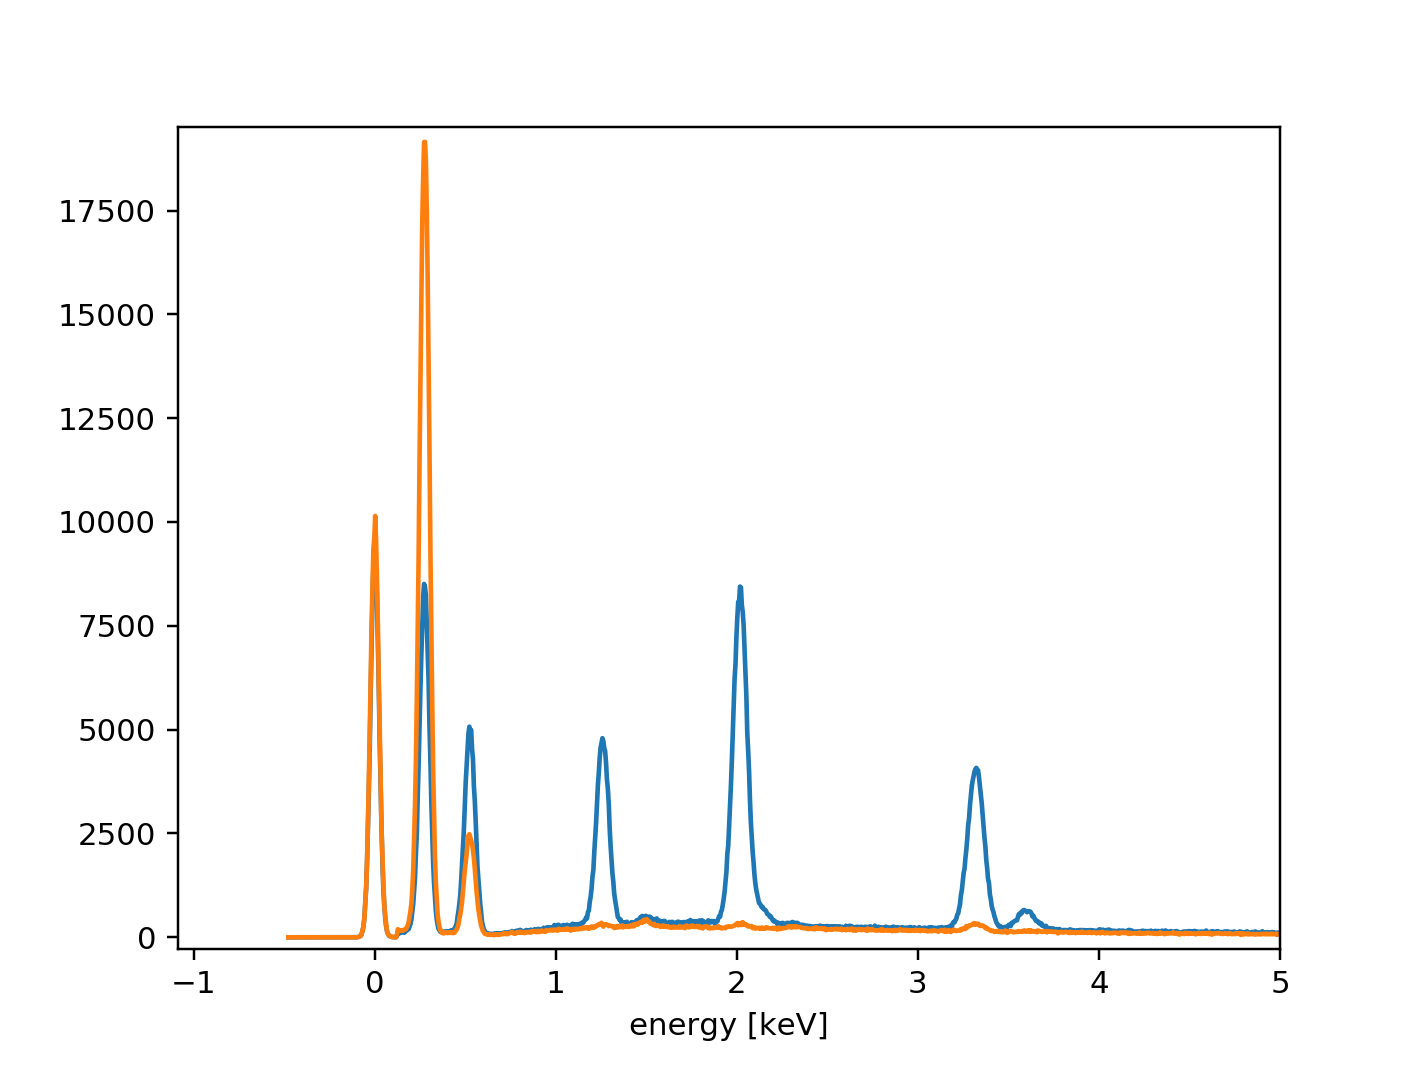

In [90]:
spectrum1 =tags[0]['data']
spectrum2 =tags[1]['data']
offset = float(tags[0]['spectrum_header']['CalibAbs'])
scale  = float(tags[0]['spectrum_header']['CalibLin'])
energy_scale1 = np.arange(len(spectrum1))*scale+offset
offset = float(tags[1]['spectrum_header']['CalibAbs'])
scale  = float(tags[1]['spectrum_header']['CalibLin'])
energy_scale2 = np.arange(len(spectrum2))*scale+offset
plt.figure()
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')
plt.plot(energy_scale2,spectrum2, label = 'spectrum 2')
plt.gca().set_xlabel('energy [keV]');



In [91]:
print(tags['overlay'].keys())
print(tags['overlay']['image1'])
#print(tags['3']['hardware_header'])
print(tags['detector'])
print(tags['esma'])
#print(tags['3']['spectrum_header'])


dict_keys(['image1', 'image2'])
{'Spectrum 1': {'posX': 483, 'posY': 504}, 'Spectrum 2': {'posX': 191, 'posY': 277}}
{'TRTKnownHeader': '\n                ', 'Technology': 'SDDpr', 'Serial': '11960', 'Type': 'XFlash 6|30', 'DetectorThickness': 0.045000000000000005, 'SiDeadLayerThickness': 2.9e-08, 'DetLayers': 'eJyzcUkt8UmsTC0qtrMB0wYKjiX5ubZKhsZKCiEZmcnZeanFxbZKpq66xkr6UDWGUDXmKEos9ICKjOCKjKCKTFEUmSGbYwxVYoZbiQlUiQWqErhV+gj3AwCpRT07', 'WindowType': 'slew AP3.3', 'window': {'Layer0': {'Z': '5', 'thickness': 1.3e-07}, 'Layer1': {'Z': '6', 'thickness': 1.45e-06}, 'Layer2': {'Z': '7', 'thickness': 4.5000000000000003e-07}, 'Layer3': {'Z': '8', 'thickness': 8.500000000000001e-07}, 'Layer4': {'Z': '13', 'thickness': 3.5000000000000004e-07}, 'Layer5': {'Z': '14', 'thickness': 0.0038000000000000004, 'relative_area': 0.23}}, 'CorrectionType': '3', 'ResponseFunctionCount': '21', 'SampleCount': '5', 'SampleOffset': '-3', 'PulsePairResTimeCount': '8', 'PileUpMinEnergy': '4.00000006E-1', 'PileUpWit

<IPython.core.display.Javascript object>


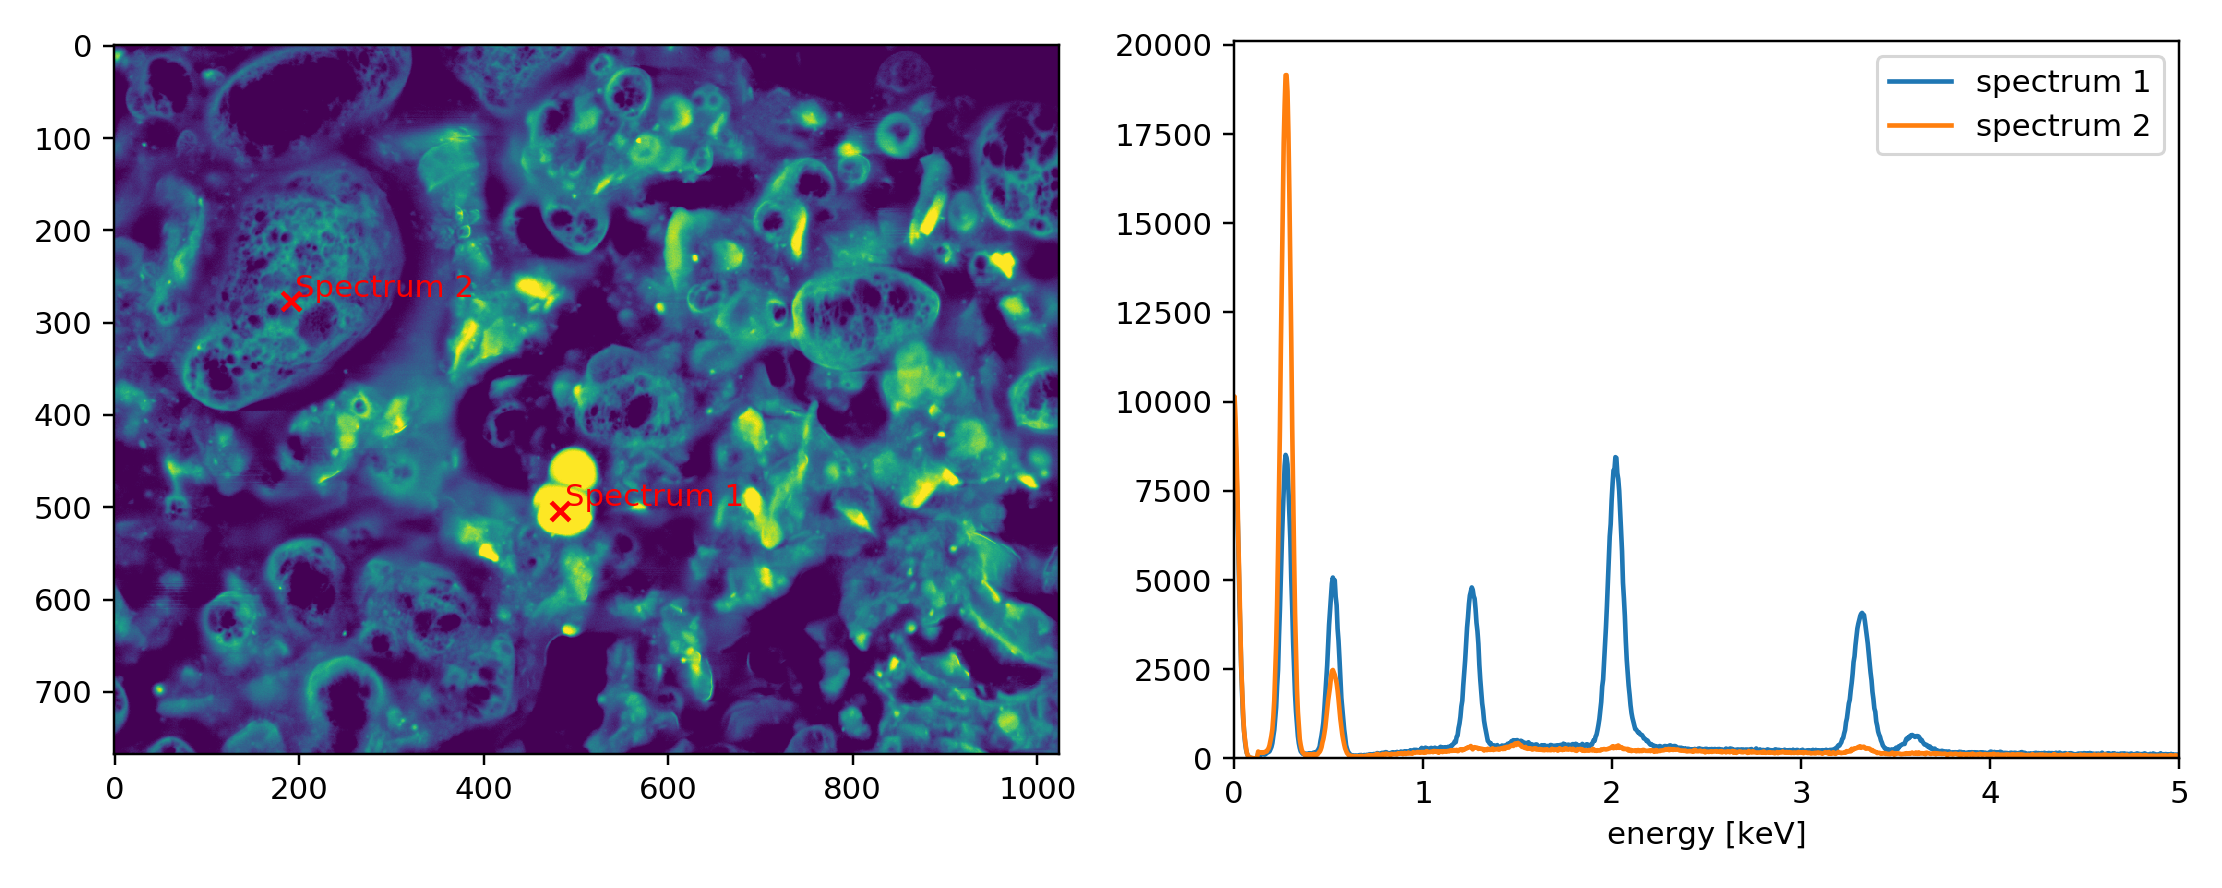

In [92]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
ax1.imshow(tags['image']['0']['data']['0'])
for key in tags['overlay']['image1']:
    d = tags['overlay']['image1'][key]
    ax1.scatter ([d['posX']], [d['posY']], marker="x", color='r')
    ax1.text(d['posX']+5, d['posY']-5, key, color='r')

ax2 = plt.subplot(1,2,2)    
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')
plt.plot(energy_scale2,spectrum2, label = 'spectrum 2')
plt.gca().set_xlabel('energy [keV]')
plt.xlim(0,5)
plt.ylim(0)
plt.tight_layout()
plt.legend();


## Find Maximas

Of course we can find the maxima with the first derivative

<IPython.core.display.Javascript object>


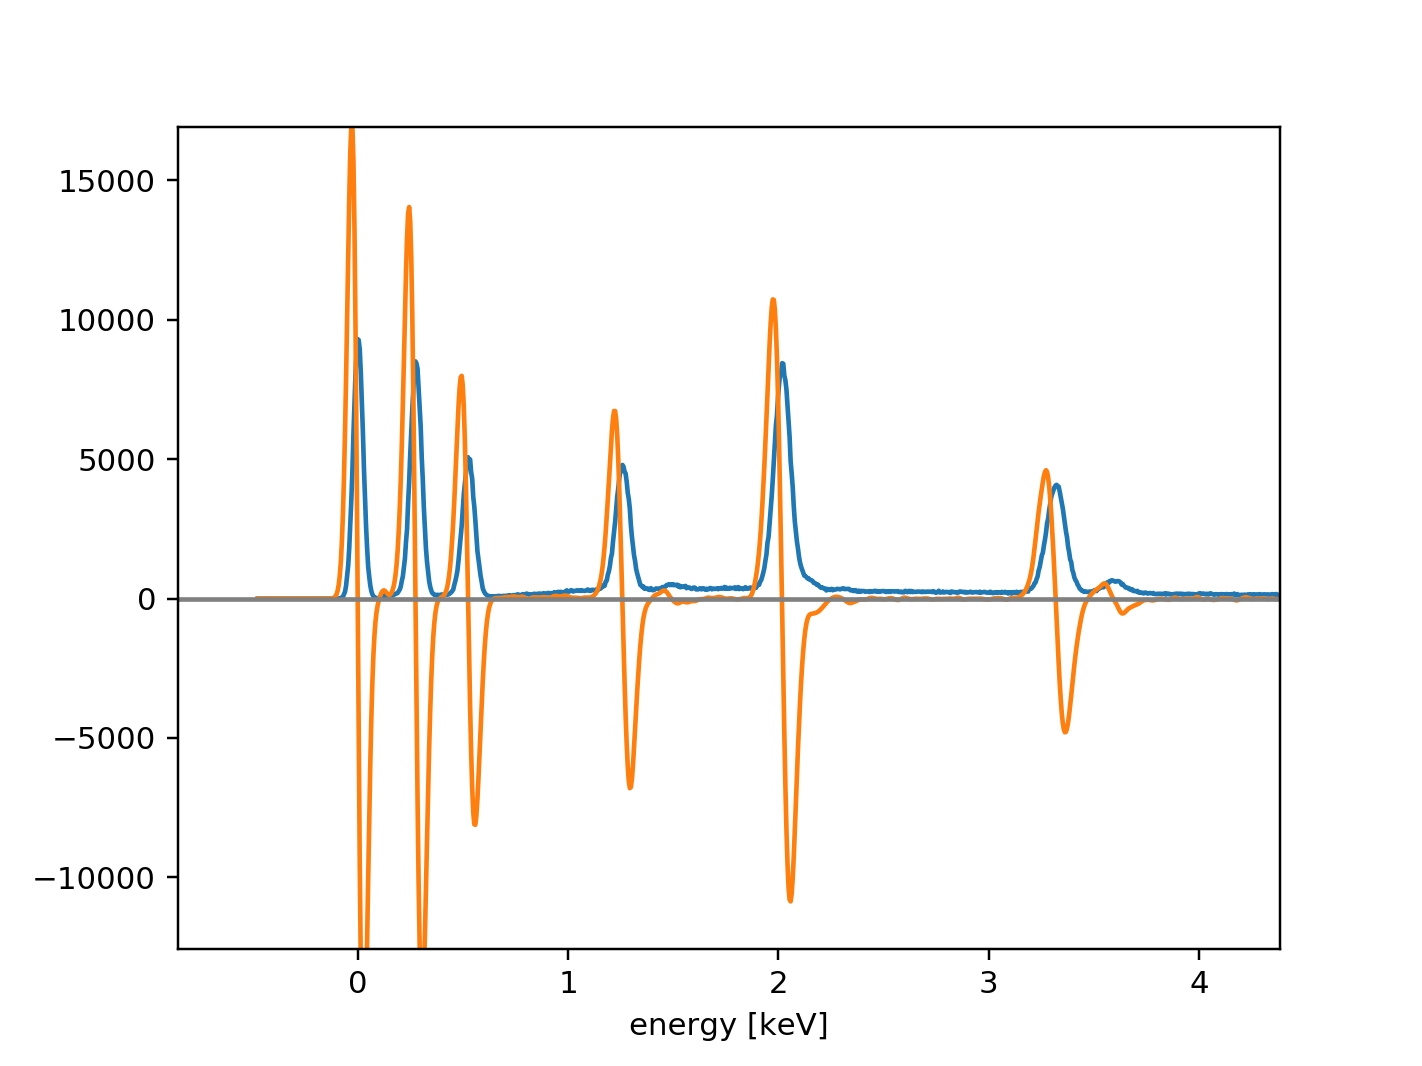

In [93]:
from scipy.interpolate import InterpolatedUnivariateSpline

# Get a function that evaluates the linear spline at any x
f = InterpolatedUnivariateSpline(energy_scale1,spectrum1, k=1)

# Get a function that evaluates the derivative of the linear spline at any x
dfdx = f.derivative()

# Evaluate the derivative dydx at each x location...
dydx = dfdx(energy_scale1)
from scipy.ndimage import gaussian_filter


plt.figure()
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')

#plt.plot(energy_scale1, dydx)
plt.plot(energy_scale1,gaussian_filter(dydx, sigma=3)/10)
plt.gca().axhline(y=0,color='gray')
plt.gca().set_xlabel('energy [keV]');

## Peak Finding

We can also use the peak finding routine of the [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) to find all the maxima.


<IPython.core.display.Javascript object>


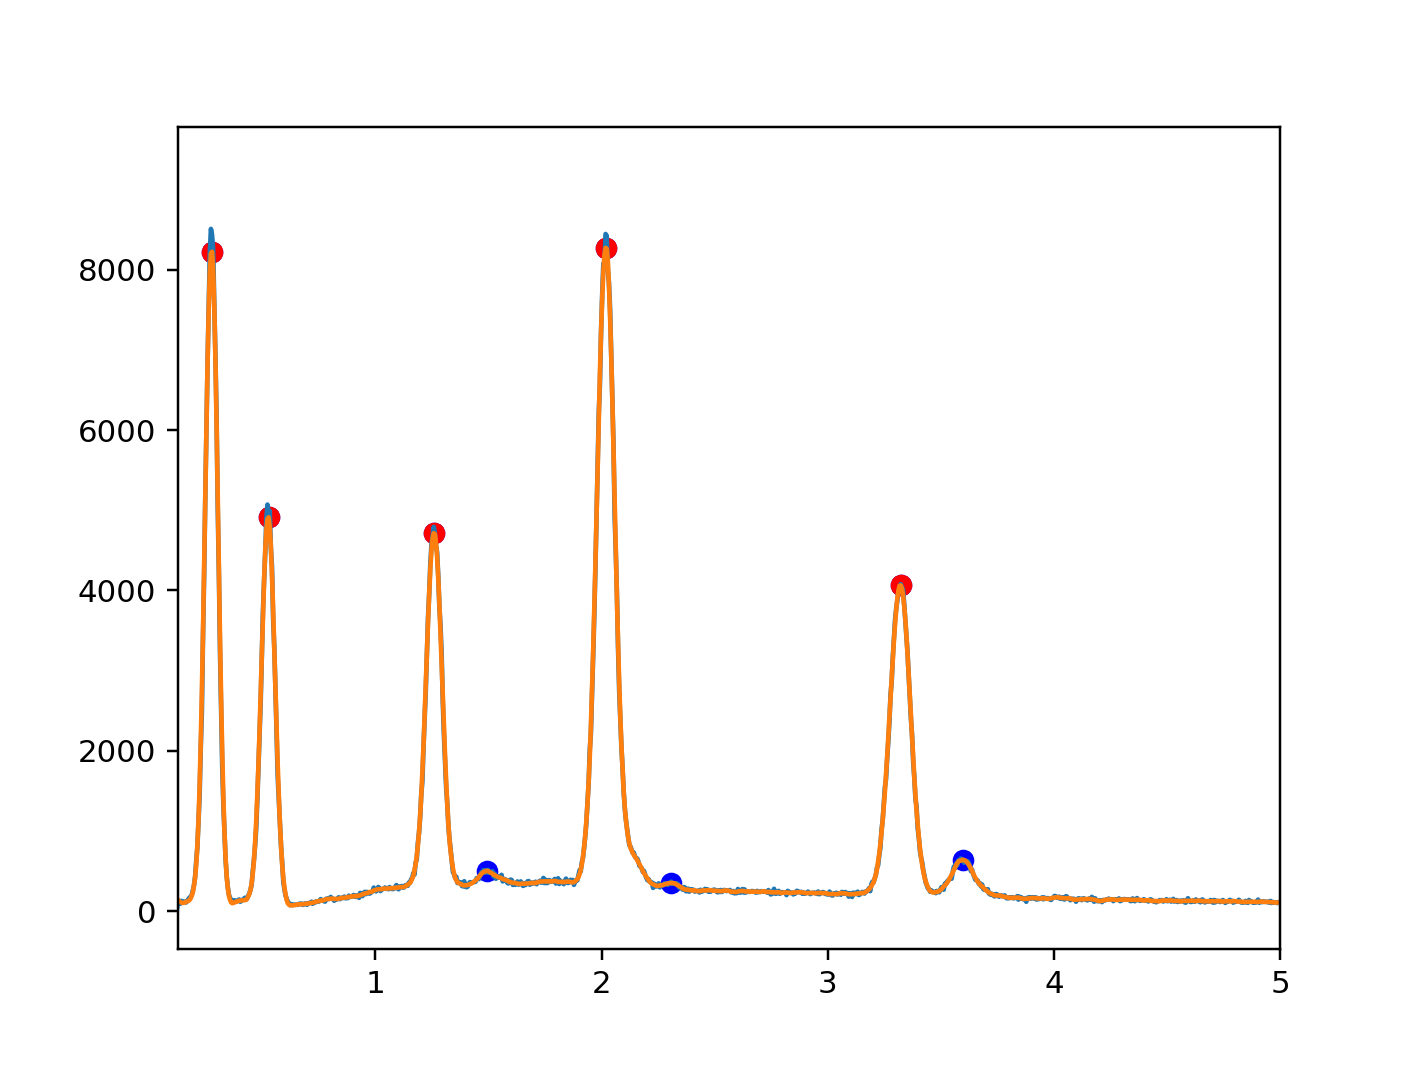

In [94]:
import scipy as sp 
import scipy.signal as sig

start = np.searchsorted(energy_scale1, 0.125)
## we use half the width of the resolution for smearing
width = int(np.ceil(125*1e-3/2 /(energy_scale1[1]-energy_scale1[0])/2)*2+1)
new_spectrum =  sp.signal.savgol_filter(spectrum1[start:], width, 2) ## we use half the width of the resolution for smearing
new_energy_scale = energy_scale1[start:]
major_peaks, _  = sp.signal.find_peaks(new_spectrum, prominence=1000)  
minor_peaks, _  = sp.signal.find_peaks(new_spectrum, prominence=30)  
peaks = major_peaks

spectrum1 = np.array(spectrum1)
plt.figure()
plt.plot(energy_scale1,spectrum1, label = 'spectrum 1')
#plt.plot(energy_scale1,gaussian_filter(spectrum1, sigma=1), label = 'filtered spectrum 1')
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.scatter( new_energy_scale[minor_peaks], new_spectrum[minor_peaks], color = 'blue')
plt.scatter( new_energy_scale[major_peaks], new_spectrum[major_peaks], color = 'red')

plt.xlim(.126,5);

## Peak identification

Here we look up all the elemetns and see whether the position of major line (K-L3, K-L2' or 'L3-M5') coincides with a peak position as found above.

Then we plot all the lines of such an element with the appropriate weight.

The positions and the weight are tabulated in the **ffast.pkl** file introduced in the [Characteristic X-Ray peaks](CH4-Characteristic_X_Rays.ipynb#X-ray-Weight-of-Lines) notebook

<IPython.core.display.Javascript object>


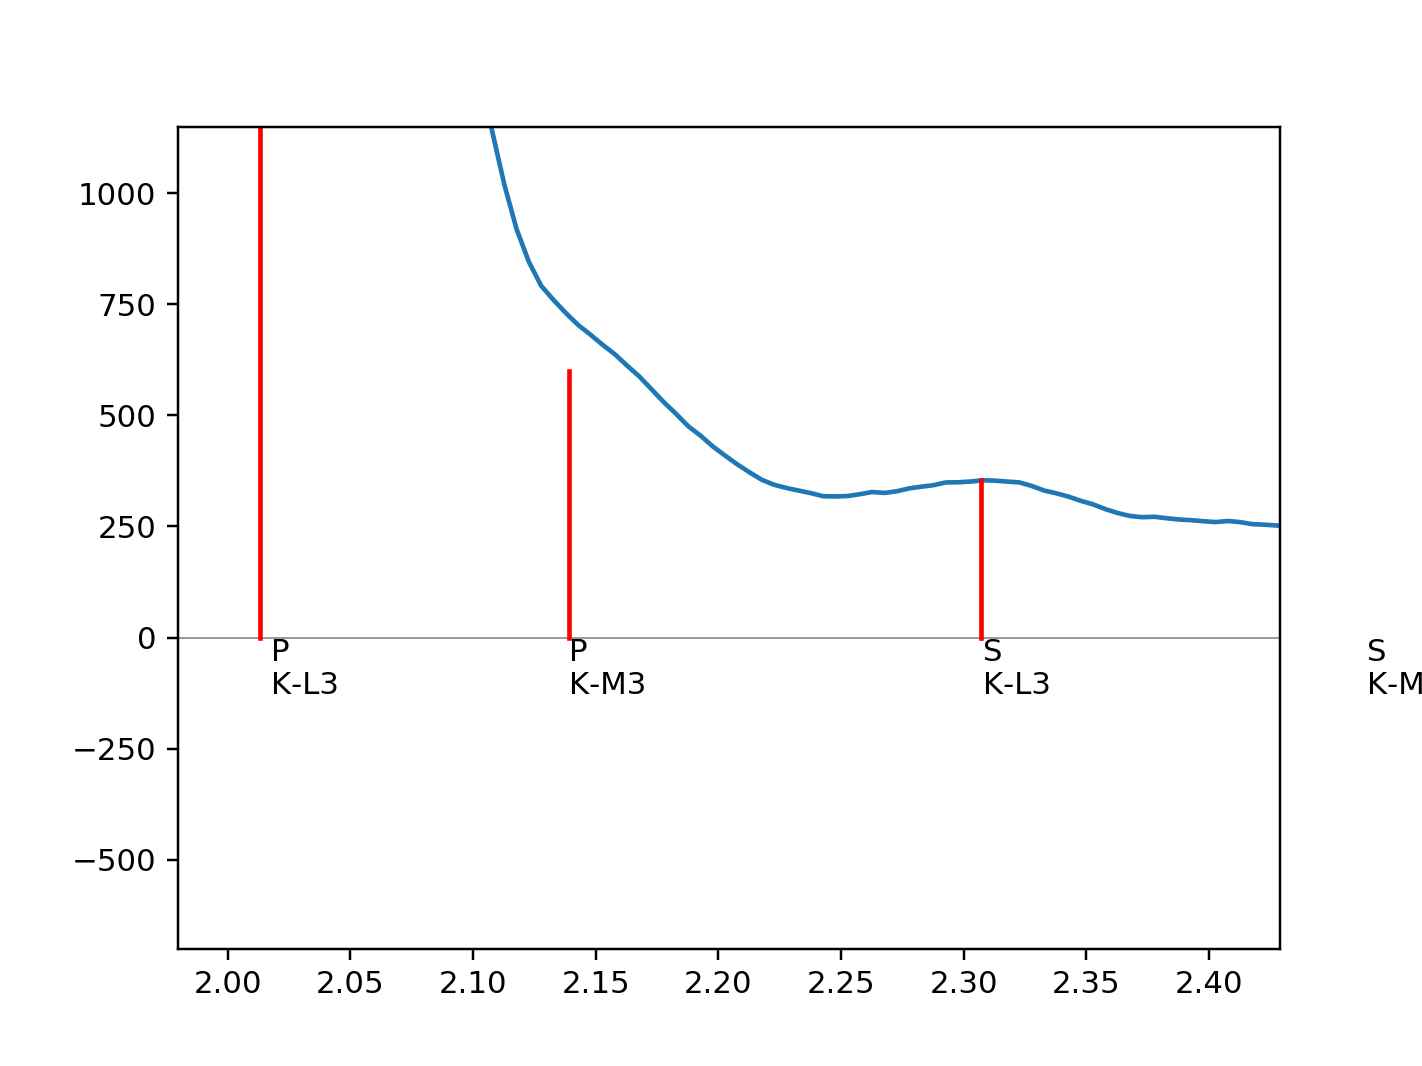

found_element 51 3604.7 3.597909755
C K-L2
O K-L3
Mg K-L3
Al K-L3
P K-L3
S K-L3
K K-L3
Sb L3-M5


In [95]:
import pickle 
pkl_file = open('data/ffast.pkl', 'rb')
ffast = pickle.load(pkl_file)
pkl_file.close()

plt.figure()
#plt.plot(energy_scale1,spectrum2, label = 'spectrum 1')
#plt.plot(energy_scale1,gaussian_filter(spectrum1, sigma=1), label = 'filtered spectrum 1')
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.xlim(0.1,4)
plt.ylim(-800)
plt.gca().axhline(y=0,color='gray',  linewidth = 0.5);

out_tags = {}
out_tags['spectra'] = {}

out_tags['spectra'][0] = {}
out_tags['spectra'][0]['data'] = spectrum1
out_tags['spectra'][0]['energy_scale'] = energy_scale1
out_tags['spectra'][0]['energy_scale_start'] = start
out_tags['spectra'][0]['smooth_spectrum'] = new_spectrum
out_tags['spectra'][0]['smooth_energy_scale'] = new_energy_scale

out_tags['spectra'][0]['elements'] ={}


#print(ffast[6])
number_of_elements = 0
for peak in minor_peaks:
    for element in range(1,93):
        if 'K-L3' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L3']['position']- new_energy_scale[peak]*1e3) <10:
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L3'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]*1e3
                number_of_elements += 1
                plt.plot([ffast[element]['lines']['K-L3']['position']/1000.,ffast[element]['lines']['K-L3']['position']/1000.], [0,new_spectrum[peak]], color = 'red')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L3', verticalalignment='top')
                for line in ffast[element]['lines']:
                    if 'K' in line:
                        if abs(ffast[element]['lines'][line]['position']-ffast[element]['lines']['K-L3']['position'])> 20:
                            if ffast[element]['lines'][line]['weight']>0.07:
                                #print(element, ffast[element]['lines'][line],new_spectrum[peak]*ffast[element]['lines'][line]['weight'])
                                plt.plot([ffast[element]['lines'][line]['position']/1000.,ffast[element]['lines'][line]['position']/1000.], [0,new_spectrum[peak]*ffast[element]['lines'][line]['weight']], color = 'red')
                                plt.text(ffast[element]['lines'][line]['position']/1000.,0, ffast[element]['element']+'\n'+line, verticalalignment='top')
                            
        elif 'K-L2' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['K-L2']['position']- new_energy_scale[peak]*1e3) <10:
                plt.plot([new_energy_scale[peak],new_energy_scale[peak]], [0,new_spectrum[peak]], color = 'orange')
                plt.text(new_energy_scale[peak],0, ffast[element]['element']+'\nK-L2', verticalalignment='top')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'K-L2'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]*1e3
                
                number_of_elements += 1
        if 'L3-M5' in ffast[element]['lines']:
            if abs(ffast[element]['lines']['L3-M5']['position']- new_energy_scale[peak]*1e3) <10:
                pass
                print('found_element', element,ffast[element]['lines']['L3-M5']['position'], new_energy_scale[peak] )
                #plt.scatter( new_energy_scale[peak], new_spectrum[peak], color = 'blue')
                out_tags['spectra'][0]['elements'][number_of_elements] = {}
                out_tags['spectra'][0]['elements'][number_of_elements]['element'] = ffast[element]['element']
                out_tags['spectra'][0]['elements'][number_of_elements]['found_lines'] = 'L3-M5'
                out_tags['spectra'][0]['elements'][number_of_elements]['lines'] = ffast[element]['lines']
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_index'] = peak
                out_tags['spectra'][0]['elements'][number_of_elements]['experimental_peak_energy'] = new_energy_scale[peak]*1e3
                
                number_of_elements += 1
for element in out_tags['spectra'][0]['elements']:                
    print(out_tags['spectra'][0]['elements'][element]['element'],out_tags['spectra'][0]['elements'][element]['found_lines'])
    

In [96]:
print(out_tags['spectra'][0]['elements'][0])#['K-L2']['weight'] = 0.5
#del out_tags['spectra'][0]['elements'][7]
for ele in out_tags['spectra'][0]['elements']:
    print(out_tags['spectra'][0]['elements'][ele]['element'])
    

{'element': 'C', 'found_lines': 'K-L2', 'lines': {'K-L2': {'weight': 0.5, 'position': 277.40000000000003}}, 'experimental_peak_index': 30, 'experimental_peak_energy': 277.577755}
C
O
Mg
Al
P
S
K
Sb


## Plotting Gaussians in the Peaks

Please note the different width (FWHM). Here I guessed the peak width for two peaks.

<IPython.core.display.Javascript object>


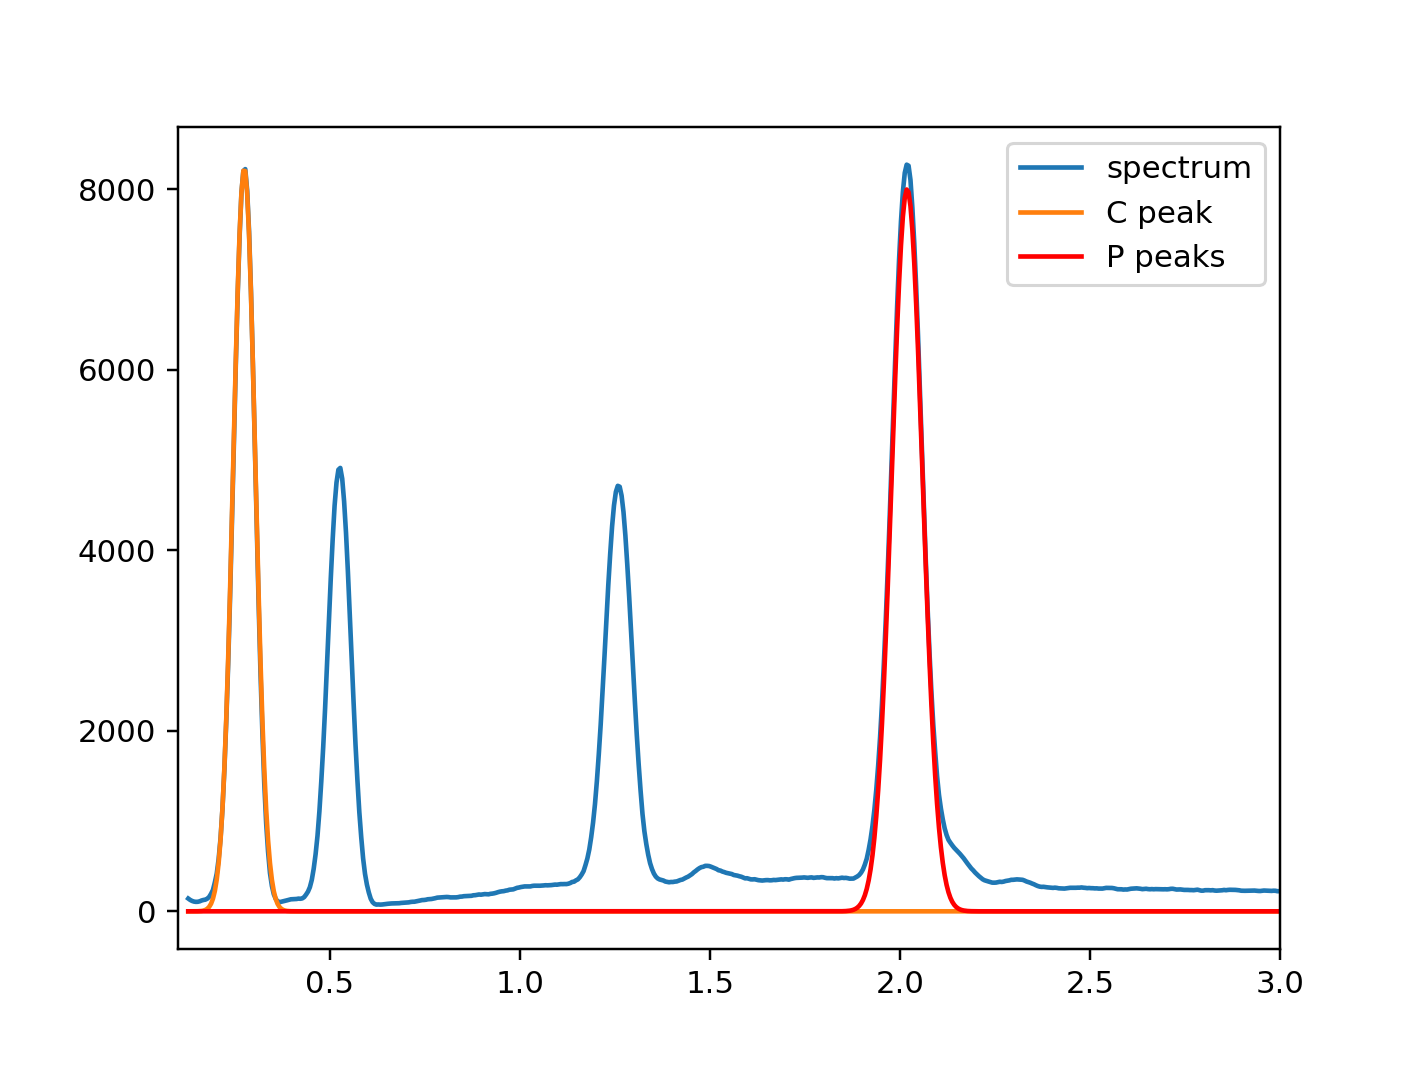

In [99]:
def gaussian(enrgy_scale, mu, FWHM):
    sig = FWHM/2/np.sqrt(2*np.log(2))
    return np.exp(-np.power(enrgy_scale - mu, 2.) / (2 * np.power(sig, 2.)))

C_peak = gaussian(new_energy_scale, .275, .068)
P_peak = gaussian(new_energy_scale, 2.019, .095)
plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'spectrum')
plt.plot(new_energy_scale,C_peak*8233, label = 'C peak')
plt.plot(new_energy_scale,P_peak*8000, label = 'P peaks', color = 'red')
plt.xlim(.1,3)
plt.legend()

## Origin of Line Width

Electron hole pairs are created with a standard deviation corresponding to the quantum mechanical shot-noise (Poisson statistic).
The distribution is then a Gaussian with the width of the standard deviation $\sigma$.

For the Mn K-L2,3 peak< this width would be 40 electron hole pairs.
The full width at half maximum (FWHM) of the Mn K-L2,3 edge would then be (FWHM of Gaussian  is 2.35 * 𝜎) about 106 eV a major component of the observed 125 eV in good EDS systems.


##  Line Width Estimate
Fiori and Newbury 1978
From a reference peak at $E_{ref}$  and the measured FWHM of the peak $FWHM_{ref}$ in eV, we can estimate the peak width of the other peaks

$$ FWHM =  \sqrt{2.5 \times (E-E_{ref}) + FWHM_{ref}^2 }$$ 

Gernerally we use the Mn K-L2,3 peak $E_{ref}$ = 5895 eV as a reference. In our spectrometer we got for the setup above: $FWHM_{ref} = 136$ eV

In [100]:
E_ref = 5895.0
FWHM_ref = 136 #eV
E= 275 
def getFWHM(E):
    return np.sqrt(2.5*(E-E_ref)+FWHM_ref**2)

print(getFWHM(E))

66.6783323126786


Using that we get for all peaks in the low energy region:

<IPython.core.display.Javascript object>


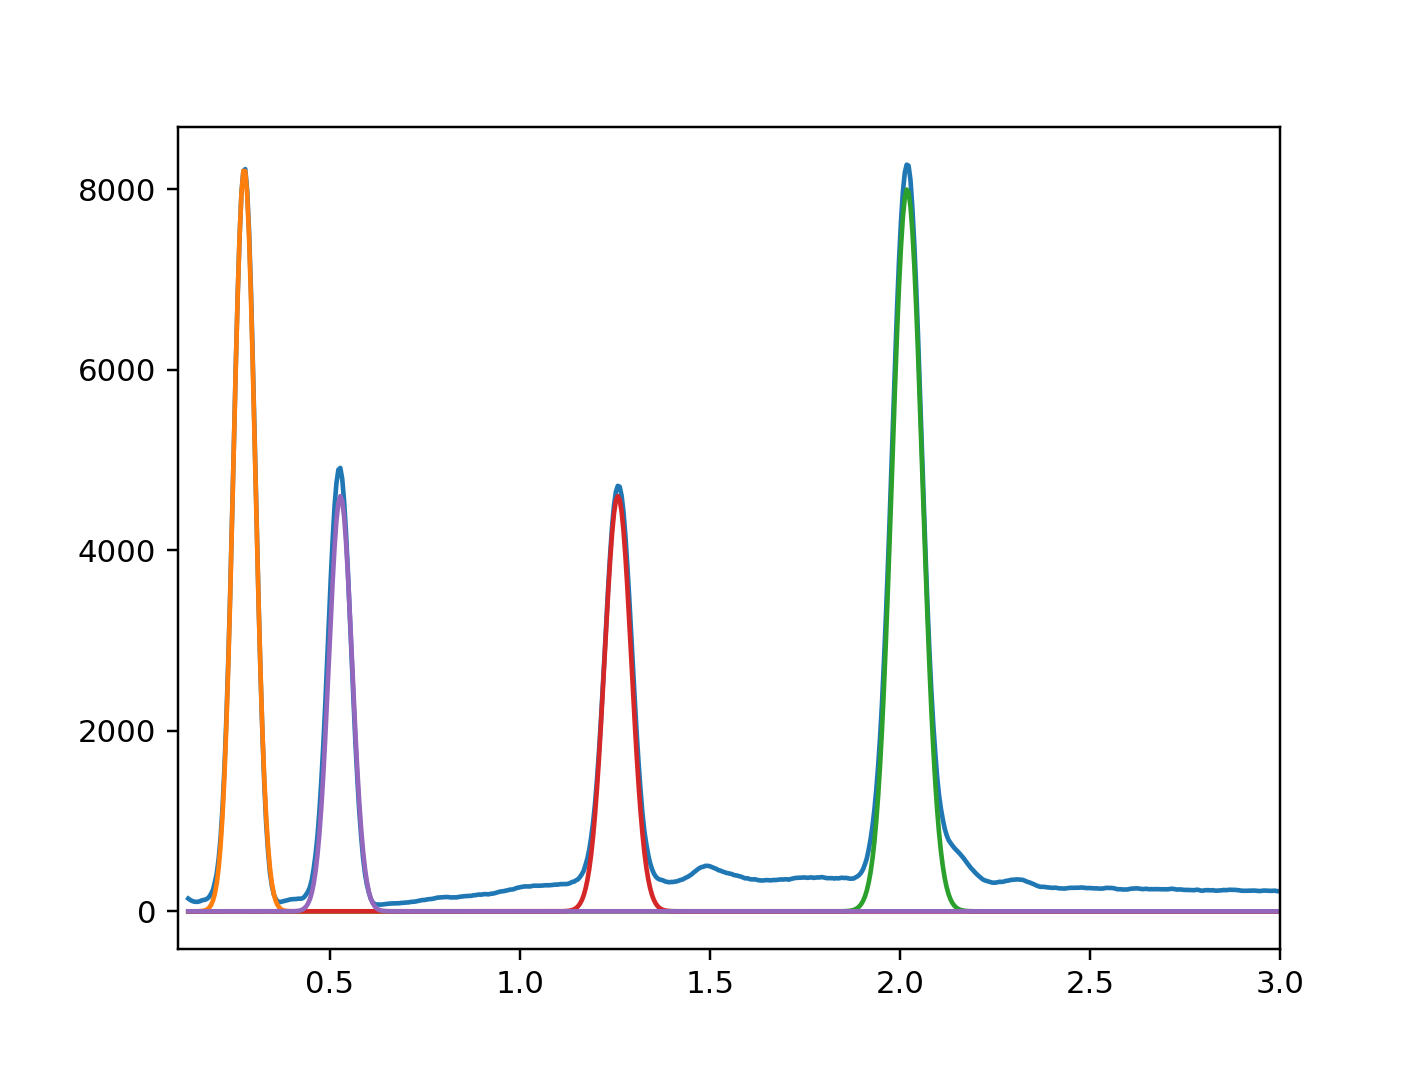

(0.1, 3)

In [101]:
def getPeak(E, energy_scale):
    E_ref = 5895.0
    FWHM_ref = 136 #eV
    FWHM  = np.sqrt(2.5*(E*1e3-E_ref)+FWHM_ref**2)*1e-3
    return gaussian(energy_scale, E, FWHM)
    
E= .275 
C_peak = getPeak(E,new_energy_scale)
E = 2.019
P_peak = getPeak(E,new_energy_scale)
E = 1.258
Al_peak = getPeak(E,new_energy_scale)
E = 0.528
O_peak = getPeak(E,new_energy_scale)
plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,C_peak*8233, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,P_peak*8000, label = 'filtered spectrum 1')
plt.plot(new_energy_scale,Al_peak*4600, label = 'filtered spectrum 1')

plt.plot(new_energy_scale,O_peak*4600, label = 'filtered spectrum 1')
plt.xlim(.1,3)

## Detector Efficiency

<IPython.core.display.Javascript object>


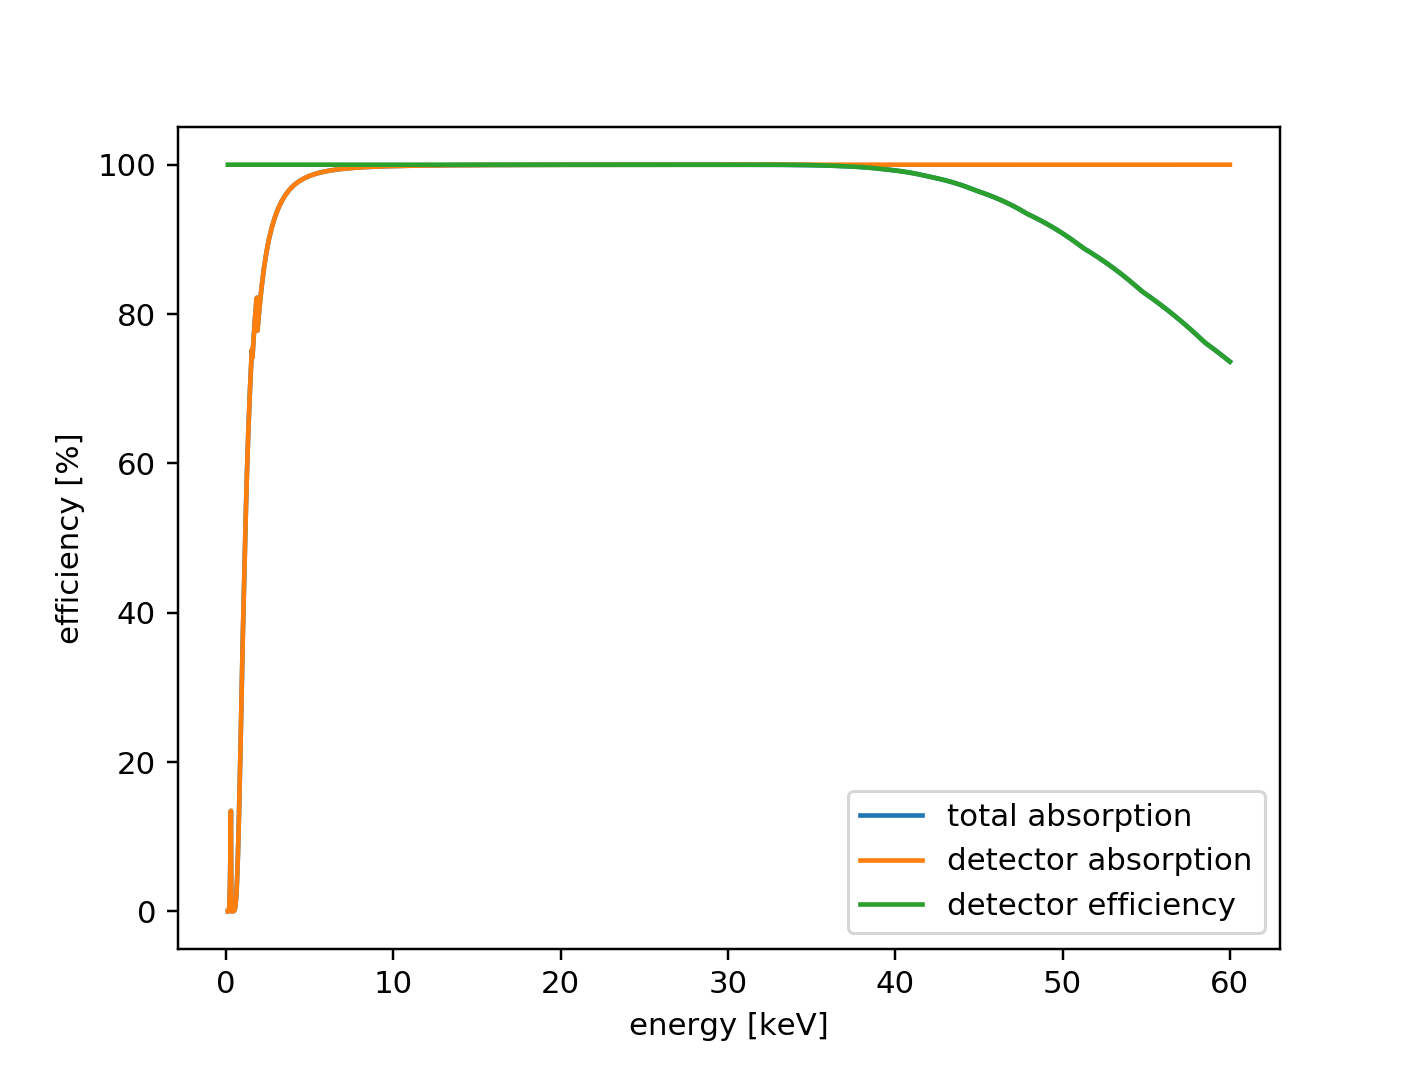

In [102]:
from scipy.interpolate import interp1d
import scipy.constants as const


## layer thicknesses of commen materials in EDS detectors in m
nickelLayer = 0.* 1e-9 # in m
alLayer = 30 *1e-9    # in m
C_window = 2 *1e-6    # in m
goldLayer = 0.* 1e-9   # in m
deadLayer = 100 *1e-9  # in m
detector_thickness = 45 * 1e-3  # in m

area = 30 * 1e-6 #in m2
oo4pi = 1.0 / (4.0 * np.pi)

#We make a linear energy scale 
energy_scale = np.linspace(.1,60,2000)

## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[14]['E']/1000.,ffast[14]['photoabsorption'],kind='linear') 
mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m

## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[13]['E']/1000.,ffast[13]['photoabsorption'],kind='linear') 
mu_Al = lin(energy_scale) * ffast[13]['nominal_density'] *100. #1/cm -> 1/m

lin = interp1d(ffast[6]['E']/1000.,ffast[6]['photoabsorption'],kind='linear') 
mu_C = lin(energy_scale) * ffast[6]['nominal_density'] *100. #1/cm -> 1/m
 
detector_Efficiency1 = np.exp(-mu_C * C_window) * np.exp(-mu_Al * alLayer)* np.exp(-mu_Si * deadLayer) 
detector_Efficiency2 = (1.0 - np.exp(-mu_Si * detector_thickness))# * oo4pi;
detector_Efficiency =detector_Efficiency1 * detector_Efficiency2#* oo4pi;

plt.figure()
plt.plot(energy_scale, detector_Efficiency*100, label = 'total absorption')
plt.plot(energy_scale, detector_Efficiency1*100, label = 'detector absorption')
plt.plot(energy_scale, detector_Efficiency2*100, label= 'detector efficiency')
plt.gca().set_xlabel('energy [keV]');
plt.gca().set_ylabel('efficiency [%]') 
plt.legend();
energy_scale = new_energy_scale

## Detector Parameters from file

In [103]:
print(tags['detector']['window'])
print(tags['detector'].keys())
print(f"{float(tags['detector']['SiDeadLayerThickness'])*1e-6:.3g}")
print(f"{float(tags['detector']['DetectorThickness'])/10:.3f}")
for key in tags['detector']['window']:
    print(f"{tags['detector']['window'][key]['Z']}, {tags['detector']['window'][key]['thickness']*1e-6:.2g}")

{'Layer0': {'Z': '5', 'thickness': 1.3e-07}, 'Layer1': {'Z': '6', 'thickness': 1.45e-06}, 'Layer2': {'Z': '7', 'thickness': 4.5000000000000003e-07}, 'Layer3': {'Z': '8', 'thickness': 8.500000000000001e-07}, 'Layer4': {'Z': '13', 'thickness': 3.5000000000000004e-07}, 'Layer5': {'Z': '14', 'thickness': 0.0038000000000000004, 'relative_area': 0.23}}
dict_keys(['TRTKnownHeader', 'Technology', 'Serial', 'Type', 'DetectorThickness', 'SiDeadLayerThickness', 'DetLayers', 'WindowType', 'window', 'CorrectionType', 'ResponseFunctionCount', 'SampleCount', 'SampleOffset', 'PulsePairResTimeCount', 'PileUpMinEnergy', 'PileUpWithBG', 'TailFactor', 'ShelfFactor', 'ShiftFactor', 'ShiftFactor2', 'ShiftData', 'PPRTData'])
2.9e-14
0.005
5, 1.3e-13
6, 1.5e-12
7, 4.5e-13
8, 8.5e-13
13, 3.5e-13
14, 3.8e-09


## Comparison to generic efficiency

5 1.3e-07
6 1.45e-06
7 4.5000000000000003e-07
8 8.500000000000001e-07
13 3.5000000000000004e-07
2.9e-14
3e-08
0.0045000000000000005
0.045


<IPython.core.display.Javascript object>


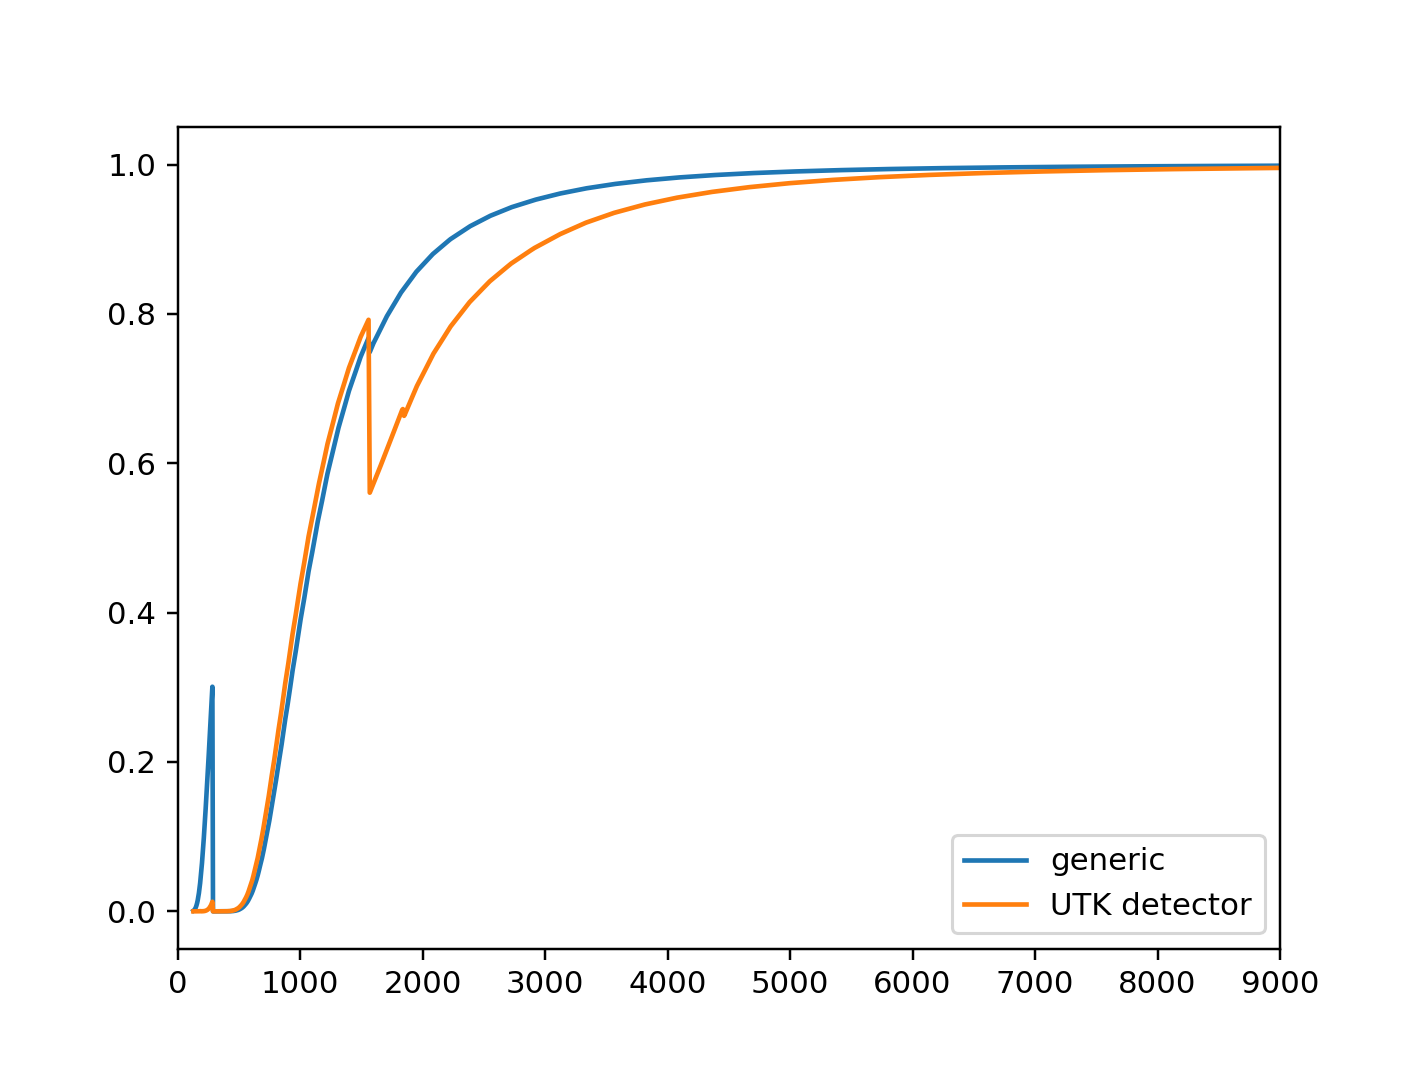

In [104]:
from scipy.interpolate import interp1d
import scipy.constants as const

def detector_efficiency(tags, energy_scale):
    detector_Efficiency1 = np.ones(len(energy_scale))
    for key in tags['detector']['window']:
        Z = int(tags['detector']['window'][key]['Z'])
        if Z < 14:
            t = tags['detector']['window'][key]['thickness']

            ## interpolate mass absorption coefficient to our energy scale
            lin = interp1d(ffast[Z]['E']/1000.,ffast[Z]['photoabsorption'],kind='linear') 
            mu = lin(energy_scale) * ffast[Z]['nominal_density']*100. #1/cm -> 1/m
            detector_Efficiency1 = detector_Efficiency1 * np.exp(-mu * t)
            print(Z,t)
        
    t = float(tags['detector']['SiDeadLayerThickness'])*1e-6
    print(t)
    t = .30*1e-7
    print(t)
    lin = interp1d(ffast[14]['E']/1000.,ffast[14]['photoabsorption'],kind='linear') 
    mu = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m
    detector_Efficiency1 = detector_Efficiency1 * np.exp(-mu * t)
    detector_thickness = float(tags['detector']['DetectorThickness'])*1e-1
    ## interpolate mass absorption coefficient to our energy scale
    mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m
    print(detector_thickness)
    
    detector_Efficiency2 = (1.0 - np.exp(-mu * detector_thickness))# * oo4pi;

    
    return detector_Efficiency1*detector_Efficiency2
de = detector_efficiency(tags, energy_scale)    
## layer thicknesses of commen materials in EDS detectors in m
nickelLayer = 0.* 1e-9 # in m
alLayer = 30 *1e-9    # in m
C_window = 2 *1e-6    # in m
goldLayer = 0.* 1e-9   # in m
deadLayer = 100 *1e-9  # in m
detector_thickness = 45 * 1e-3  # in m
print(detector_thickness)
area = 30 * 1e-6 #in m2
oo4pi = 1.0 / (4.0 * np.pi)

#We make a linear energy scale 
energy_scale = new_energy_scale


## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[14]['E']/1000.,ffast[14]['photoabsorption'],kind='linear') 
mu_Si = lin(energy_scale) * ffast[14]['nominal_density']*100. #1/cm -> 1/m

## interpolate mass absorption coefficient to our energy scale
lin = interp1d(ffast[13]['E']/1000.,ffast[13]['photoabsorption'],kind='linear') 
mu_Al = lin(energy_scale) * ffast[13]['nominal_density'] *100. #1/cm -> 1/m

lin = interp1d(ffast[6]['E']/1000.,ffast[6]['photoabsorption'],kind='linear') 
mu_C = lin(energy_scale) * ffast[6]['nominal_density'] *100. #1/cm -> 1/m
 
detector_Efficiency1 = np.exp(-mu_C * C_window) * np.exp(-mu_Al * alLayer)#* np.exp(-mu_Si * deadLayer) 
detector_Efficiency2 = (1.0 - np.exp(-mu_Si * detector_thickness))# * oo4pi;
detector_Efficiency =detector_Efficiency1 * detector_Efficiency2#* oo4pi;

plt.figure()
plt.plot(energy_scale*1000, detector_Efficiency , label = 'generic')
plt.plot(energy_scale*1000, de, label = 'UTK detector')
#plt.plot(energy_scale*1000, de* np.exp(-mu_Si * deadLayer) )
#plt.plot(energy_scale*1000, de* np.exp(-mu_Si * deadLayer) * detector_Efficiency2 )
plt.legend();
plt.xlim(0,9000);


## Plotting background and lines 

<IPython.core.display.Javascript object>


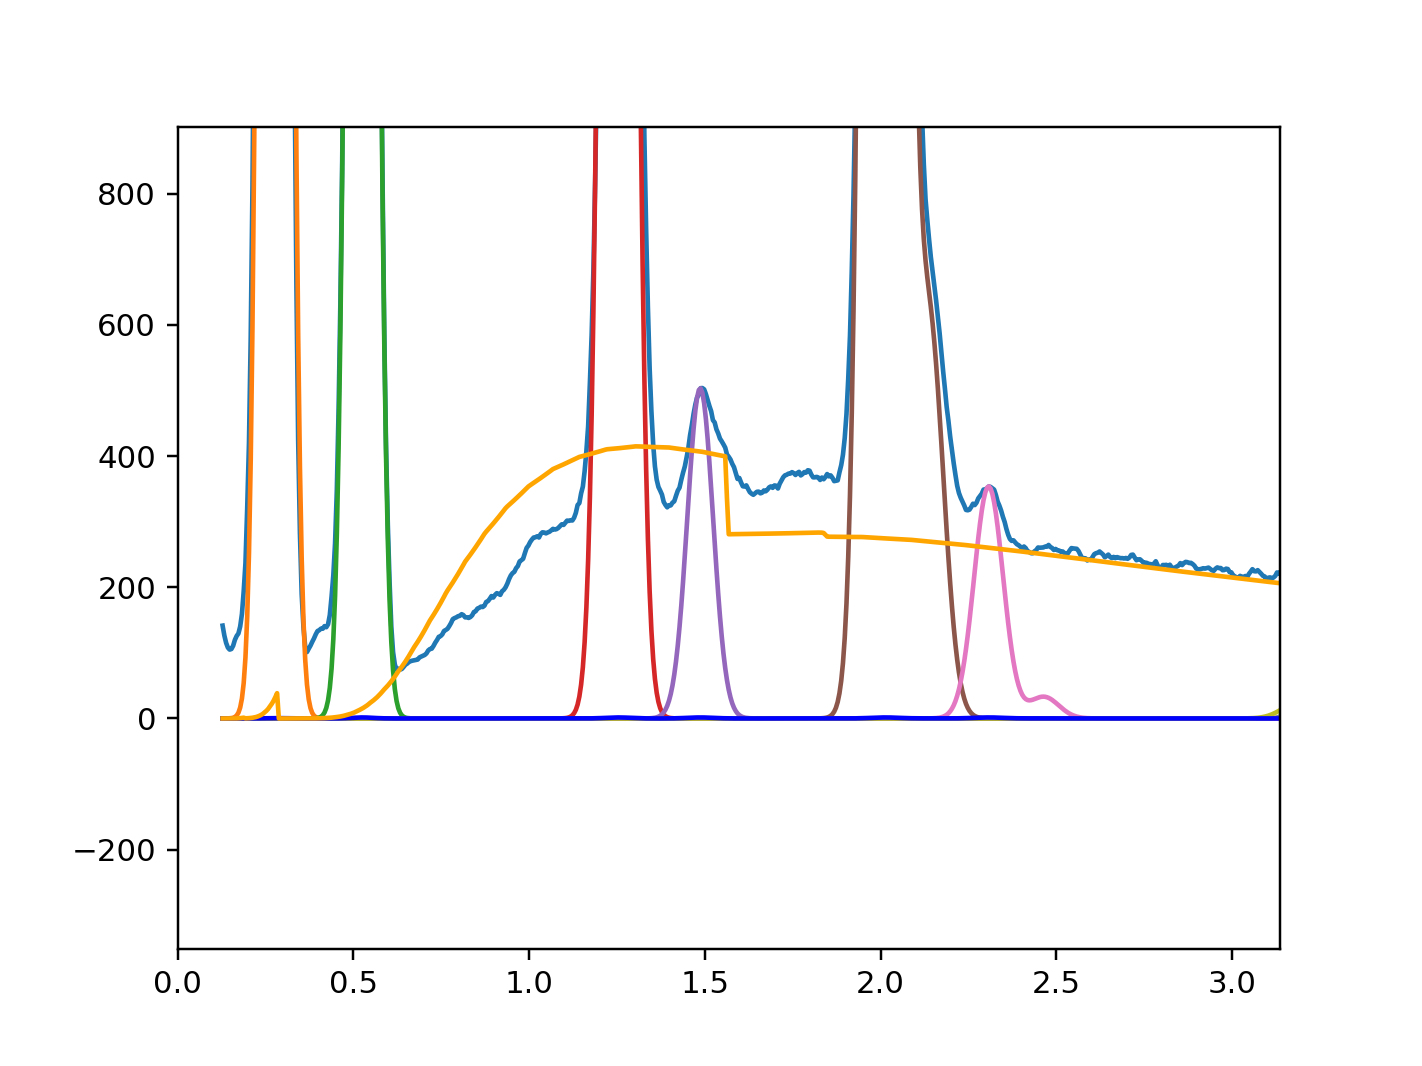

(29, 3922)


In [105]:
Peaks = []
elements_peaks = []
intensities = []
for element in out_tags['spectra'][0]['elements']:
    el_dict = out_tags['spectra'][0]['elements'][element]
    
    position = el_dict['lines'][el_dict['found_lines']]['position']
    weight = 0
    for line in el_dict['lines']:
        if abs(position - el_dict['lines'][line]['position'])<20:
            weight += el_dict['lines'][line]['weight']
    index = np.searchsorted(new_energy_scale,el_dict['lines'][el_dict['found_lines']]['position']/1000.)  
    intensity = new_spectrum[index]/weight
    added_peaks = np.zeros(len(new_energy_scale))
    for line in el_dict['lines']: 
        if line[0] == el_dict['found_lines'][0]:
            if el_dict['lines'][line]['weight']> 0.01:
                p = getPeak(el_dict['lines'][line]['position']/1000.,new_energy_scale)*el_dict['lines'][line]['weight']
                Peaks.append(p)
                added_peaks = added_peaks + p 
    elements_peaks.append(added_peaks)        
    intensities.append(intensity)
    
plt.figure()
plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1')
#plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
for i in range(len(elements_peaks)):
    plt.plot(new_energy_scale,elements_peaks[i]*intensities[i], label = f'Peak{i}')
    pass
peaks = np.array(Peaks)
plt.plot(new_energy_scale,peaks.sum(axis=0), label = f'Peaks', color = 'blue')
print(peaks.shape)
#plt.xlim(0,5)    
offset = float(tags[0]['spectrum_header']['CalibAbs'])
scale  = float(tags[0]['spectrum_header']['CalibLin'])
energy_scale1 = np.arange(len(spectrum1))*scale+offset
p = [1, 37, .3, offset, scale]
E_0= 20
E = new_energy_scale
N = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
N = de * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)

pp = p[0:5].copy()
for i in range(len(elements_peaks)):
    pp.append(intensities[i])

plt.plot(new_energy_scale,N, color= 'orange')

plt.xlim(0,4)

detector_Efficiency = de

## As a function

<IPython.core.display.Javascript object>


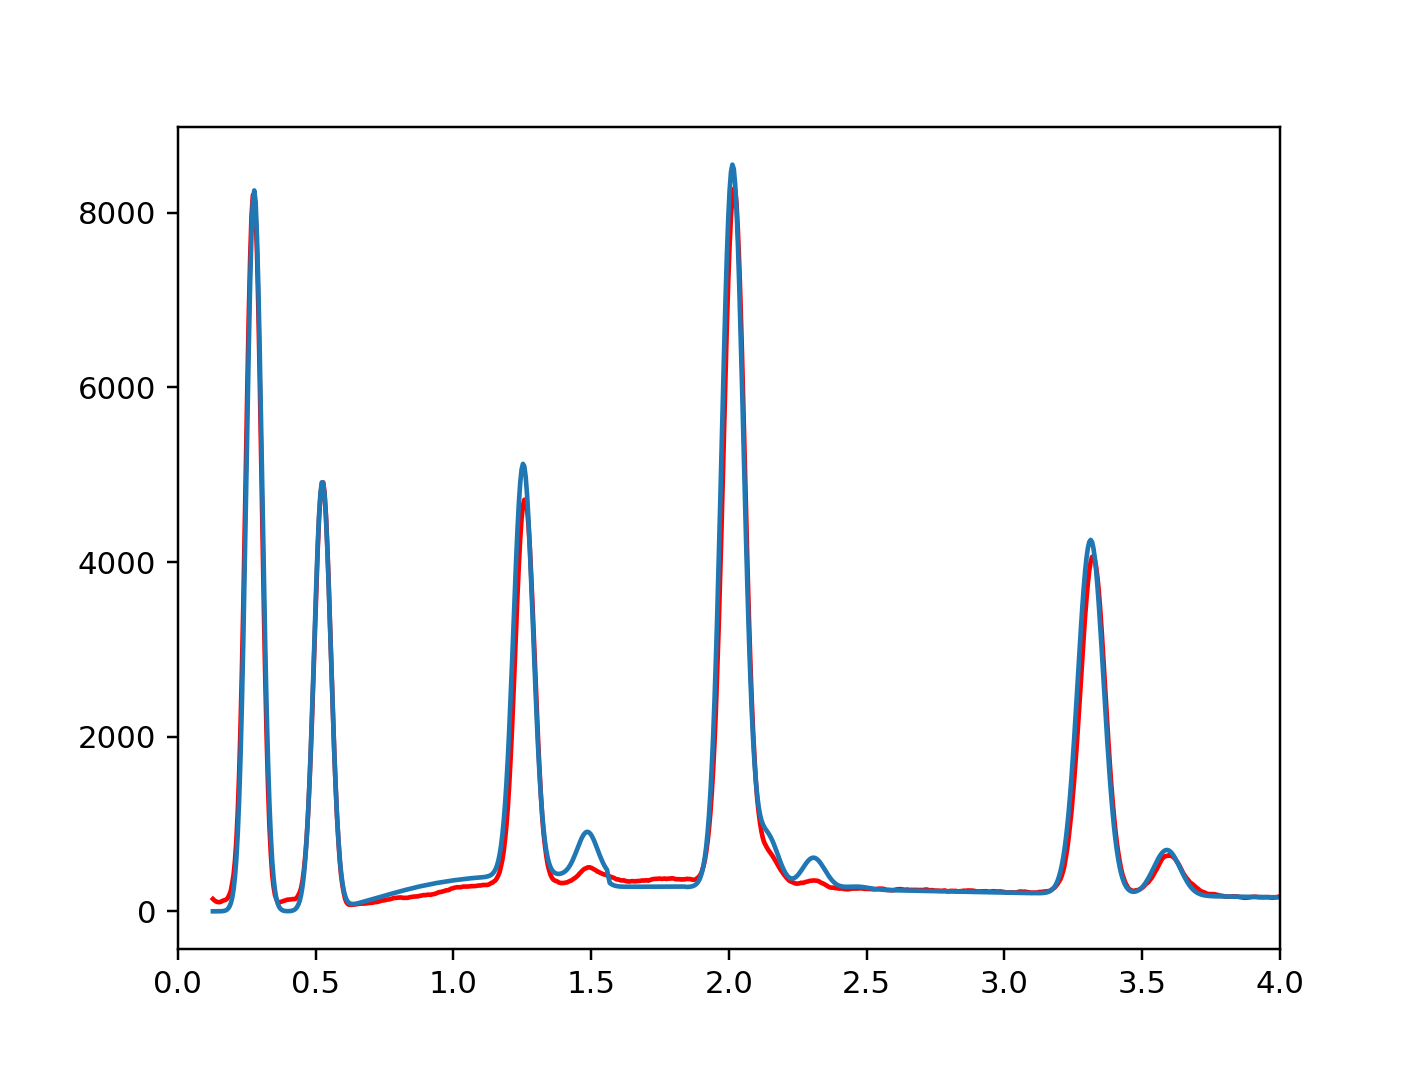

(0, 4)

In [106]:
def model(p,energy_scale):
    E = energy_scale
    
    spectrum = detector_Efficiency * (p[0] + p[1]*(E_0-E)/E + p[2]*(E_0-E)**2/E)
    
    for i in range(5,len(p)):
        spectrum = spectrum+elements_peaks[i-5]*abs(p[i])
    return spectrum
spectrum3 = model(pp[:-1],new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.xlim(0,4)

## Fitting above function to spectrum

In [107]:

from scipy.optimize import leastsq 

## background fitting 
def specfit(p, y, x):
    err = y - model(p,x)
    return err

p, lsq = leastsq(specfit, pp[:-1], args=(new_spectrum, new_energy_scale), maxfev=2000)


In [108]:
print( f'element\t end   \t   start ')
for i, element in enumerate(out_tags['spectra'][0]['elements']):
    if i<len(p)-5:
        el_dict = out_tags['spectra'][0]['elements'][element]
        print(f"{el_dict['element']:2s}: \t  {abs(p[i+5]):6.2f} \t  {pp[i+5]:.2f}")
#print(p,pp)

element	 end   	   start 
C : 	  16487.64 	  16444.49
O : 	  3267.00 	  3274.63
Mg: 	  2831.85 	  3127.80
Al: 	   84.40 	  334.63
P : 	  5267.50 	  5499.66
S : 	   82.35 	  234.96
K : 	  2526.57 	  2693.25


<IPython.core.display.Javascript object>


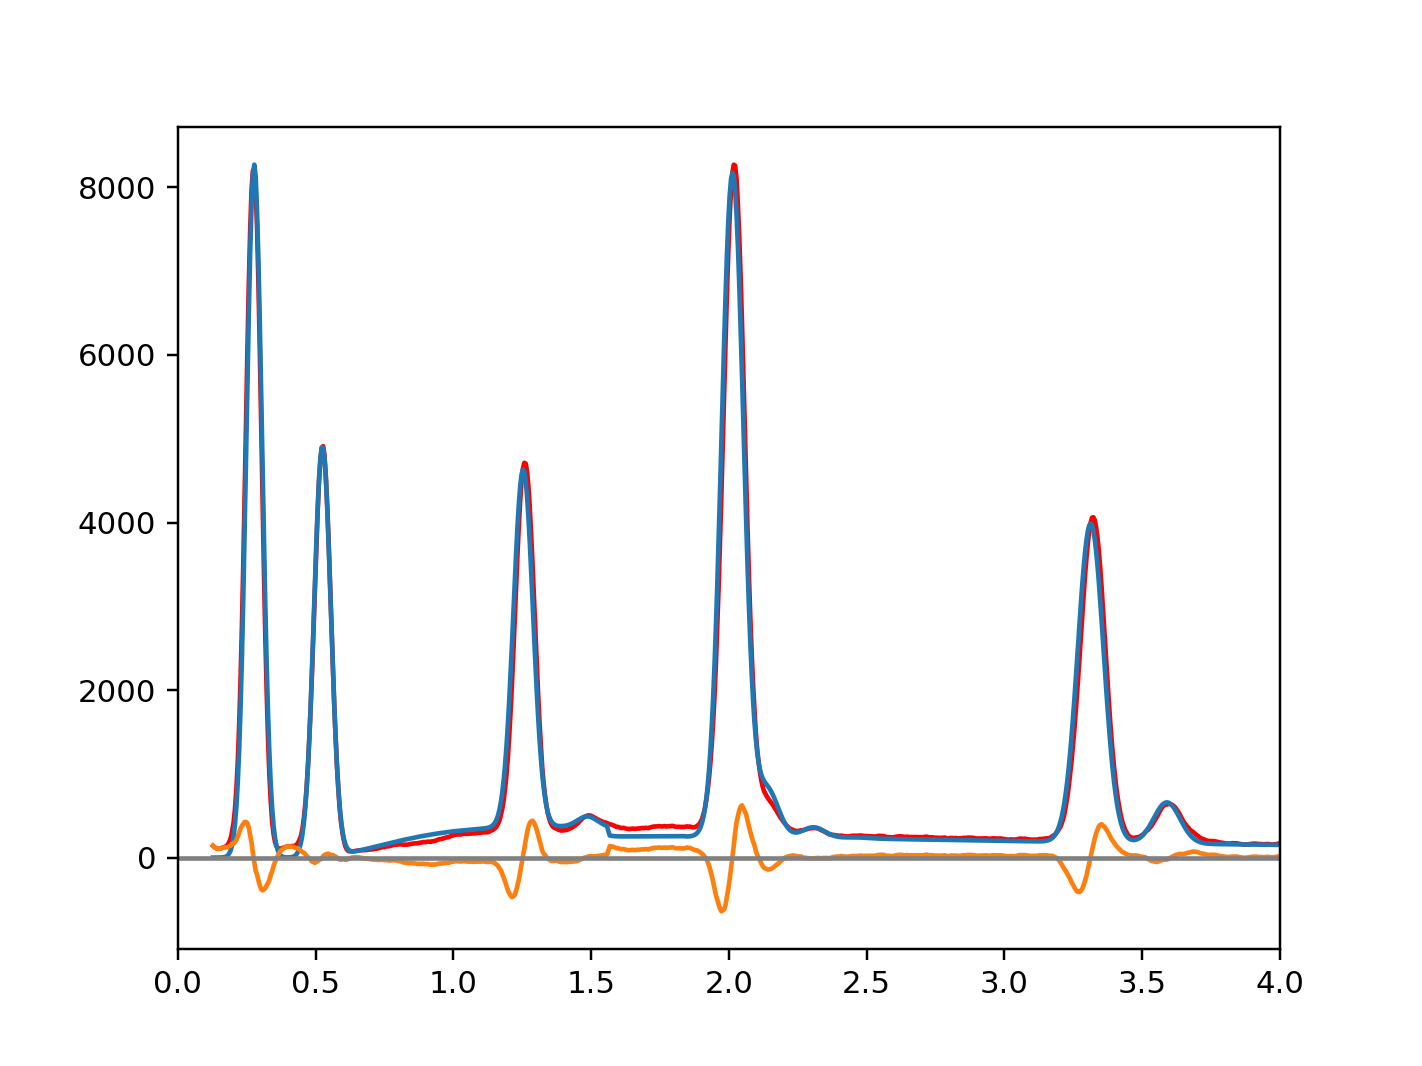

In [109]:
spectrum3 = model(p,new_energy_scale)

plt.figure()

plt.plot(new_energy_scale,new_spectrum, label = 'filtered spectrum 1',color='red')
plt.plot(new_energy_scale, spectrum3)
plt.plot(new_energy_scale, new_spectrum-spectrum3)
plt.gca().axhline(y=0,color='gray');

plt.xlim(0,4);

## Energy Scale

What happened?


## Detector Artifacts

### Si Escape peak
The 1s state of a Si atom in the detector crystal is excited but then instead of being further detected by absoption a A!!uger electron leaves the crystal. The electron hole pairs of this event are missing and a lower energy is recorded. 

![Si-Escape](./images_SEM/escape-peak2.jpg)

### Detector Silicon Peak
Internal fluorescence peak

![Si-Detector](./images_SEM/DetectorSilicon4.jpg)

### Sum Peak
Two photons are detected at the same time.
This signal is suppressed by most acquistion systems, but a few are still slipping through.
A peak apears at the energy of the sum of two strong peaks.

# Composition
Following 

[D.E. Newbury, C.R. Swyt, and R.L. Myklebust,
“Standardless” Quantitative Electron Probe
Microanalysis with Energy-Dispersive X-ray
Spectrometry: Is It Worth the Risk?, Anal. Chem. 1995, 67, 1866-1871](https://doi-org.proxy.lib.utk.edu/10.1021/ac00107a017)

to calculate the mass concentration $C_i$ from the intensity of a line ($I_{ch}$), we use:

$$ I_{ch} = \epsilon  (\omega N_A \rho C_i / A) R \int _{E_c}^{E_0} \frac{Q_i}{dE/ds}dE $$


- $\omega$ : fluorescence yield    
- $N_A$: Avogadro’s number          
- $\rho$: density                       
- $C_i$: mass concentration of element $i$  
- $A$:atomic weight           
- $R$: backscatter loss
- $Q_i$: ionization cross sectiond
- $E/ds$: rate of energy loss 
- $E_0$: incident beam energy  
- $E_c$: excitation energy
- $\epsilon$: EDS efficiency

where: $N_A * \rho * C_i/A$: volume density of element $i$ (atoms per unit volume)  

What do we know at this point?

$\omega; N_A; \rho; A; Q_i; E_0; E_c; and \epsilon$

In [79]:
def BrowningEmpiricalCrossSection(elm , energy):
    """ * Computes the elastic scattering cross section for electrons of energy between
     * 0.1 and 30 keV for the specified element target. The algorithm comes from<br>
     * Browning R, Li TZ, Chui B, Ye J, Pease FW, Czyzewski Z &amp; Joy D; J Appl
     * Phys 76 (4) 15-Aug-1994 2016-2022

     * The implementation is designed to be similar to the implementation found in
     * MONSEL.
     * Copyright: Pursuant to title 17 Section 105 of the United States Code this
     * software is not subject to copyright protection and is in the public domain
     * Company: National Institute of Standards and Technology
     * @author Nicholas W. M. Ritchie
     * @version 1.0

     */
     Modified by Gerd Duscher, UTK
    """

    #/**
    #* totalCrossSection - Computes the total cross section for an electron of
    #* the specified energy.
    #* 
    # @param energy double - In keV
    # @return double - in square meters
    #*/
    e = energy  #in keV
    re = np.sqrt(e);
    return (3.0e-22 * elm**1.7) / (e + (0.005 * elm**1.7 * re) + ((0.0007 * elm**2) / re));
   

In [84]:
print(BrowningEmpiricalCrossSection(6,277)*1e18, r'nm^2')

2.2633981858464282e-05 nm^2


## Back: [Detector Response](CH4-Detector.ipynb)
## Next: [Quantify_Spectrum](CH4-Quantify_Spectrum.ipynb)
## List of Content: [Front](_Analysis_of_Scanning_Electron_Microscope_Data.ipynb#Content)